# **Time Series Forecasting Pt. 2**
#### Author: Maslenchenko Oleksandra
#### My region: ['OtherPEN', 'Other Pen. States', 'OtherPEN']

## **Imports**

In [241]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import logging
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 9, 3
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.statespace.sarimax import SARIMAX 
import warnings
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns 
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from keras.models import Sequential
from keras.layers import Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, RepeatVector
from keras.layers import LSTM, GRU
from keras.optimizers import Adam, Adagrad, RMSprop, Nadam, Adamax, SGD, Adadelta
from scikeras.wrappers import KerasRegressor
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS 
from neuralforecast.losses.pytorch import DistributionLoss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from pmdarima import auto_arima
from darts import TimeSeries
warnings.filterwarnings('ignore')

## **Data preparation**

In [191]:
production = pd.read_csv('palm_data/production_good.csv')
rainfall = pd.read_csv('palm_data/rainfall_good.csv')
area = pd.read_csv('palm_data/area_good.csv')

variant = 80 % 7
REGIONS = [['JH', 'Johor', 'JH'], 
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'], 
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

production = production[production['Region'].isin(REGIONS[variant])]
rainfall = rainfall[rainfall['Region'].isin(REGIONS[variant])]
area = area[area['Region'].isin(REGIONS[variant])]

rainfall

,Region,Year,Month,Rainfall
123,Other Pen. States,1980,1,80.205252
124,Other Pen. States,1981,1,96.171420
125,Other Pen. States,1982,1,40.035766
126,Other Pen. States,1983,1,120.536443
127,Other Pen. States,1984,1,136.502240
...,...,...,...,...
3316,Other Pen. States,2016,12,438.937724
3317,Other Pen. States,2017,12,0.000000
3318,Other Pen. States,2018,12,0.000000
3319,Other Pen. States,2019,12,0.000000


In [192]:
def process_data(production, rainfall, area):
    data = pd.merge(production[['Year', 'Month', 'Production', 'Diff_production']],
                    rainfall[['Year', 'Month', 'Rainfall']], 
                    on=['Year', 'Month'], how='left')

    data = pd.merge(data, area[['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')
        
    data['Year'] = data['Year'].astype(int)
    data['Month'] = data['Month'].astype(int)
    data.reset_index(inplace=True)

    data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                    inplace=True)

    data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
    data['Time'] = np.arange(len(data))
    return data

In [193]:
data = process_data(production, rainfall, area)

In [194]:
class MyData:
    def __init__(self, data, train=0.7, validation=0.15):
        self.full_df = data

        self.production_df = data[['Month', 'Production', 'Time']].copy()
        self.rainfall_df = data[['Month', 'Rainfall', 'Time']].copy()
        self.area_df = data[['Month', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_ma_new', 'Time']].copy()

        self.index = data.index

        train_size = int(len(data) * train)
        val_size = int(len(data) * validation)

        self.full_train_df = data[:train_size]
        self.full_validation_df = data[train_size:train_size + val_size]
        self.full_test_df = data[train_size + val_size:]
        self.full_train_val_df = data[:train_size + val_size]

        self.train_production_df = self.full_train_df[['Month', 'Production', 'Time']].copy()
        self.train_rainfall_df = self.full_train_df[['Month', 'Rainfall', 'Time']].copy()
        self.train_area_df = self.full_train_df[['Month', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_ma_new', 'Time']].copy()

        self.val_production_df = self.full_validation_df[['Month', 'Production', 'Time']].copy()
        self.val_rainfall_df = self.full_validation_df[['Month', 'Rainfall', 'Time']].copy()
        self.val_area_df = self.full_validation_df[['Month', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_ma_new', 'Time']].copy()

        self.val_production_df = self.full_validation_df[['Month', 'Production', 'Time']].copy()
        self.val_rainfall_df = self.full_validation_df[['Month', 'Rainfall', 'Time']].copy()
        self.val_area_df = self.full_validation_df[['Month', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_ma_new', 'Time']].copy()

        self.test_production_df = self.full_test_df[['Month', 'Production', 'Time']].copy()
        self.test_rainfall_df = self.full_test_df[['Month', 'Rainfall', 'Time']].copy()
        self.test_area_df = self.full_test_df[['Month', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_ma_new', 'Time']].copy()

        self.train_val_production_df = self.full_train_val_df[['Month', 'Production', 'Time']].copy()
        self.train_val_rainfall_df = self.full_train_val_df[['Month', 'Rainfall', 'Time']].copy()
        self.train_val_area_df = self.full_train_val_df[['Month', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_ma_new', 'Time']].copy()

    def to_series(self, df):
        return pd.Series(df)

In [195]:
data = MyData(data)

## **Exogenous Factors and Feature Engineering**

#### First of all, let us visualize addtional data - rainfall and area.

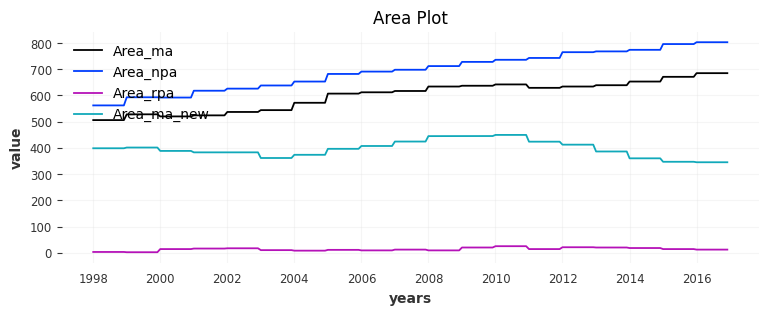

In [196]:
for column in data.area_df.columns[1:5]:
    plt.plot(data.area_df[column], label=column)

plt.xlabel('years')
plt.ylabel('value')
plt.title('Area Plot')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()

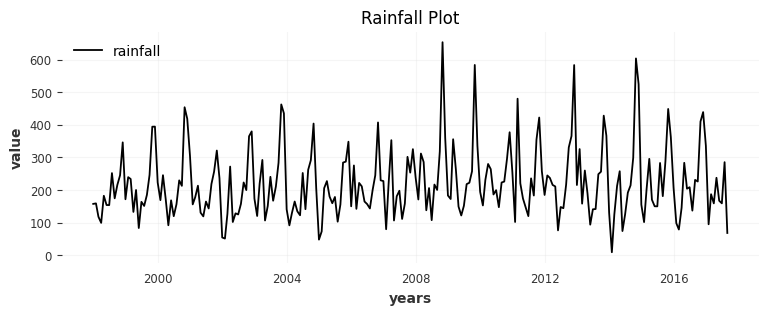

In [197]:
plt.plot(data.rainfall_df['Rainfall'], label='rainfall')
plt.xlabel('years')
plt.ylabel('value')
plt.title('Rainfall Plot')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()

#### To choose which additional time series to use as exogenous factors I can check Pearson and Spearman correlation. I will choose few that correlate with Production series the most.

In [198]:
pearson_corr = data.full_df[['Production', 'Rainfall', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_ma_new']].corr(method='pearson')
spearman_corr = data.full_df[['Production', 'Rainfall', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_ma_new']].corr(method='spearman')
mask_pearson = np.triu(np.ones_like(pearson_corr, dtype=bool))
mask_spearman = np.triu(np.ones_like(spearman_corr, dtype=bool))

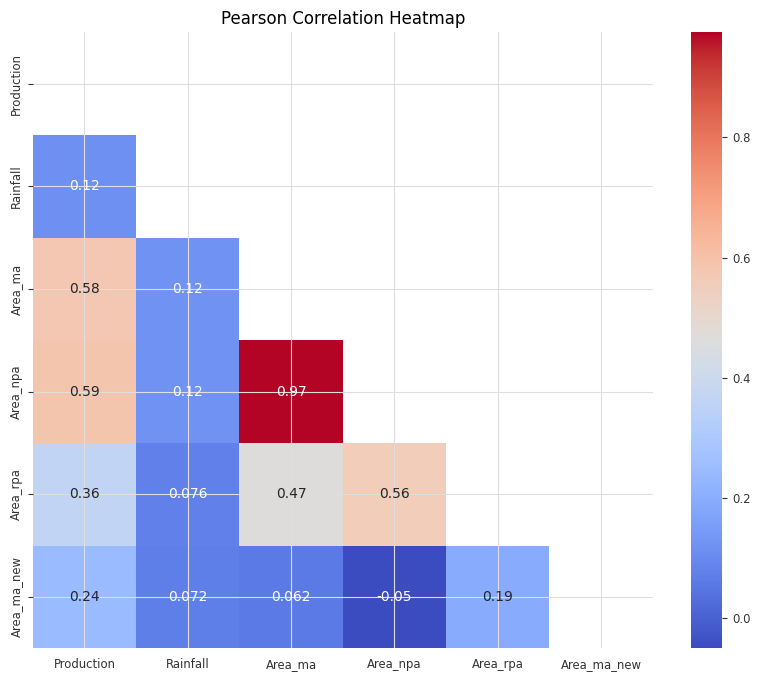

In [199]:
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', mask=mask_pearson)
plt.title('Pearson Correlation Heatmap')
plt.show()

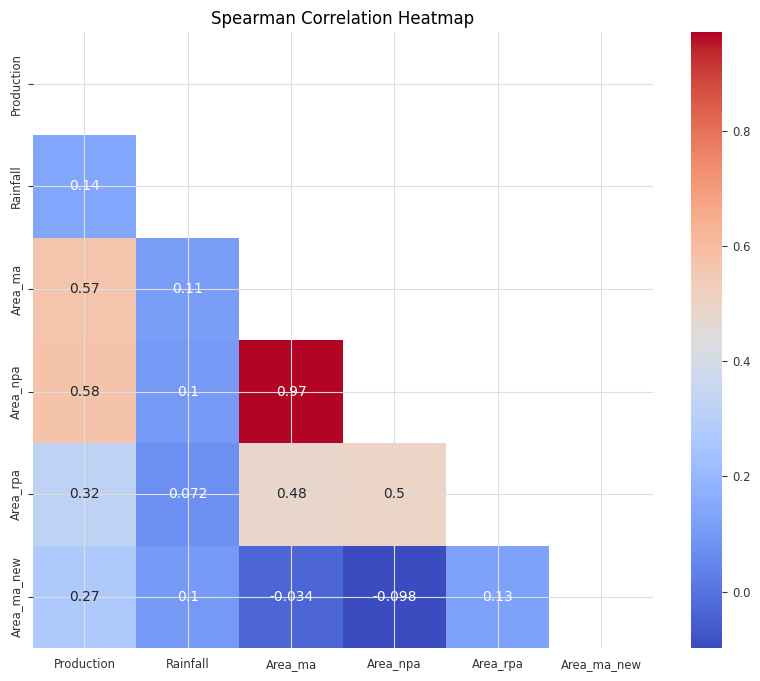

In [200]:
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', mask=mask_spearman)
plt.title('Spearman Correlation Heatmap')
plt.show()

#### As we can see, Area_ma and Area_npa correlate with Production the most, but since they correlate with each other, it is more rational to choose only one that correlate more - Area_npa. After these two factors next go Area_rpa and Rainfall. I will choose Area_rpa since the correlation is slightly bigger and it is easier to predict area than rainfall.

#### Now I can create few additional features and I decided to choose previous lags. To determine the amount of lags let's observe ACF and PACF plots.

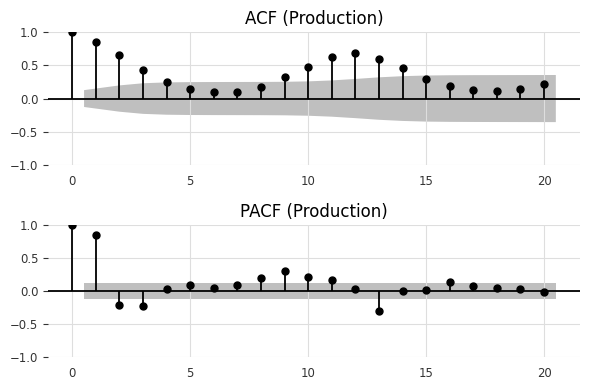

In [201]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4))
plot_acf(data.full_df['Production'], lags=20, ax=ax1)
ax1.set_title('ACF (Production)')
plot_pacf(data.full_df['Production'], lags=20, ax=ax2)
ax2.set_title('PACF (Production)')
plt.tight_layout()
plt.show()

#### It can be seen that zero lag is strongly correlated with 3 previous lags, so for prediction of each month I will use three previous ones.

In [202]:
full_feature_x = pd.concat([data.full_df['Area_rpa'], data.full_df['Area_npa']], axis=1)
for i in range(1, 4):
    full_feature_x[f"lag {i}"] = data.full_df['Production'].shift(i)
full_feature_y = data.full_df['Production']

train_size = int(len(data.full_df) * 0.7)
val_size = int(len(data.full_df) * 0.15)

train_x = full_feature_x[:train_size]
train_y = full_feature_y[:train_size]

validation_x = full_feature_x[train_size:train_size + val_size]
validation_y = full_feature_y[train_size:train_size + val_size]

train_x = train_x.dropna()
train_y = train_y.loc[train_x.index]

#### In the Production dataset we have values that start in 1998 and end in 2017. But for Area we have data only until 2016, so it is necessary to predict values for 2017. Also, since Area_npa and Area_rpa are used as features, when I will train models on a train set, I have to predict values for validation period. When training on train and validation datasets, I need to predict values for test period. It prevents model from overfitting and gives a better picture of how good model works.

#### To predict values I will use polyfit() function.

In [203]:
def fit_poly(train, validation_idx, validation=None):
    val_start = len(train)
    val_end = len(train) + len(validation_idx)
    coeffs_train = np.polyfit(np.arange(len(train)), train, deg=1)
    poly_mdl = np.poly1d(coeffs_train)
    fitted_trend = pd.Series(data=poly_mdl(np.arange(len(train))), index=train.index)
    predicted_trend = pd.Series(data=poly_mdl(np.arange(val_start, val_end)), index=validation_idx)
    if validation is not None:
        mape_trend = round(mape(validation, predicted_trend.to_numpy()), 3) * 100
    plt.plot(train, label='train data')
    plt.plot(fitted_trend, label='fitted trend')
    plt.plot(predicted_trend, label='predicted trend (validation set)')
    plt.legend()
    if validation is not None:
        plt.title(f'order = 1\nMAPE: {mape_trend}%')
    plt.show()
    return predicted_trend

In [204]:
data.full_test_df['Area_npa'].tail(10)

2016-12-01    803.0
2017-01-01      NaN
2017-02-01      NaN
2017-03-01      NaN
2017-04-01      NaN
2017-05-01      NaN
2017-06-01      NaN
2017-07-01      NaN
2017-08-01      NaN
2017-09-01      NaN
Name: Area_npa, dtype: float64

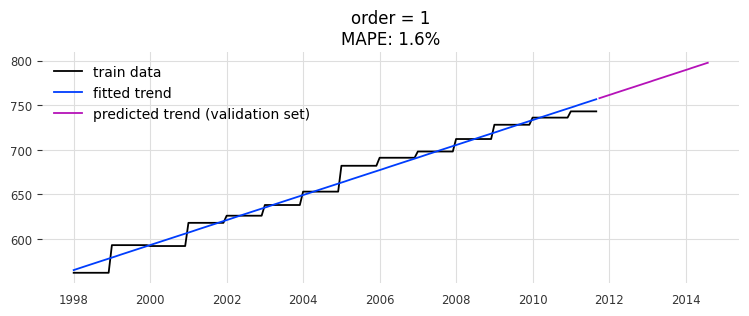

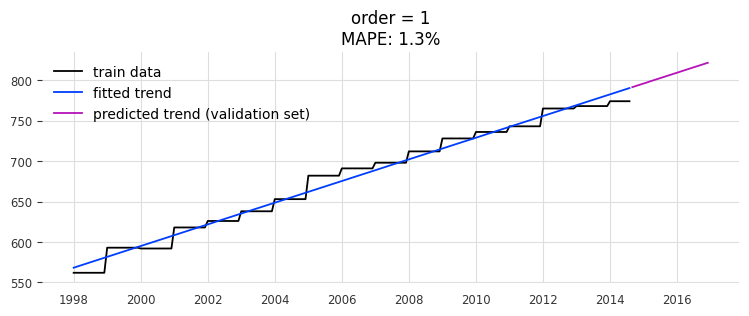

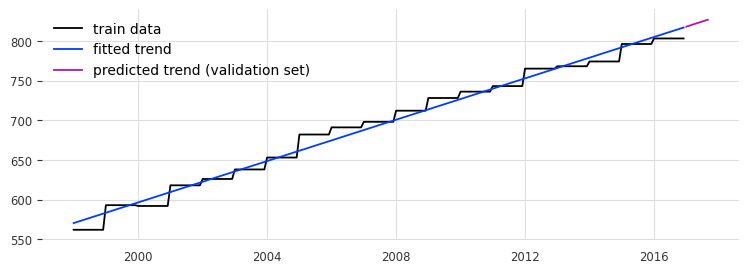

2017-05-01    822.188215
2017-06-01    823.273526
2017-07-01    824.358836
2017-08-01    825.444146
2017-09-01    826.529456
Name: Area_npa, dtype: float64


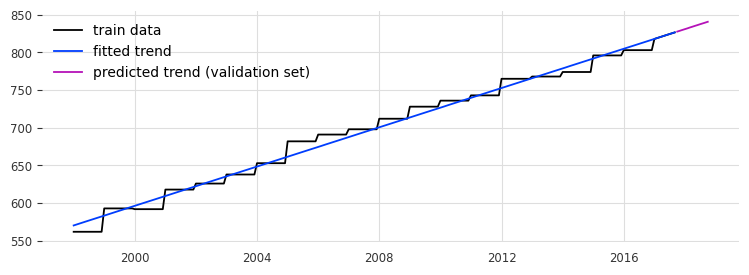

In [205]:
start_date = '2017-01-01'
end_date = '2017-09-01'
dates = pd.date_range(start=start_date, end=end_date, freq='MS')
dates_list_test_end = dates.to_list()

start_date = '2017-10-01'
end_date = '2018-10-01'
dates = pd.date_range(start=start_date, end=end_date, freq='MS')
dates_list_future = dates.to_list()

predicted_val_area_npa = fit_poly(data.full_train_df['Area_npa'], data.full_validation_df['Area_npa'].index, data.full_validation_df['Area_npa'].values)
predicted_test_1_area_npa = fit_poly(data.full_train_val_df['Area_npa'], data.full_test_df['Area_npa'].dropna().index, data.full_test_df['Area_npa'].dropna().values)
predicted_test_2_area_npa = fit_poly(data.full_df['Area_npa'].dropna(), dates_list_test_end)
predicted_test_area_npa = pd.concat([predicted_test_1_area_npa, predicted_test_2_area_npa])

combined_npa = pd.concat([data.full_df['Area_npa'].dropna(), predicted_test_2_area_npa]).sort_index()
combined_npa = combined_npa[~combined_npa.index.duplicated(keep='first')]
end_date = pd.to_datetime('2017-09-01')
combined_npa = combined_npa[combined_npa.index <= end_date]

combined_npa_test = combined_npa[train_size + val_size:]
data.full_df['Area_npa'] = combined_npa.values
data.area_df['Area_npa'] = combined_npa.values
data.full_test_df['Area_npa'] = combined_npa_test.values
data.test_area_df['Area_npa'] = combined_npa_test.values

print(data.full_df['Area_npa'].tail())

predicted_future_area_npa = fit_poly(data.full_df['Area_npa'], dates_list_future)

data.full_df['Area_npa'] = data.full_df.groupby(data.full_df.index.year)['Area_npa'].transform('mean')
data.area_df['Area_npa'] = data.area_df.groupby(data.area_df.index.year)['Area_npa'].transform('mean')
data.full_test_df['Area_npa'] = data.full_test_df.groupby(data.full_test_df.index.year)['Area_npa'].transform('mean')
data.test_area_df['Area_npa'] = data.test_area_df.groupby(data.test_area_df.index.year)['Area_npa'].transform('mean')


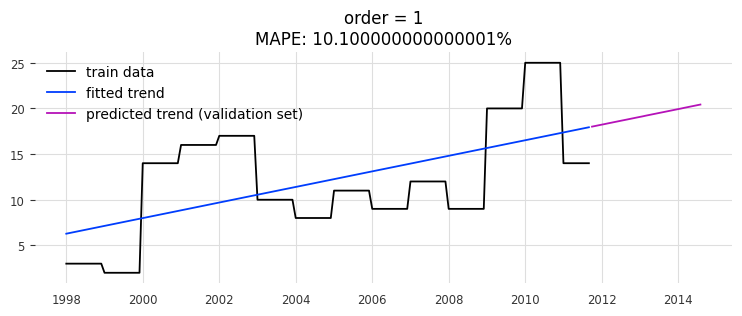

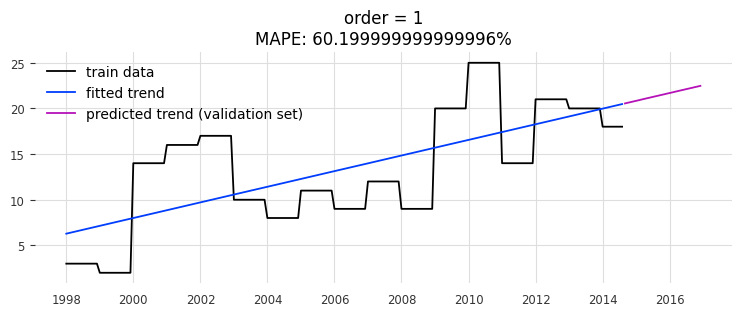

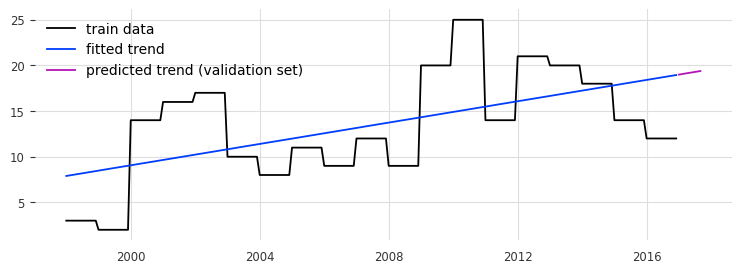

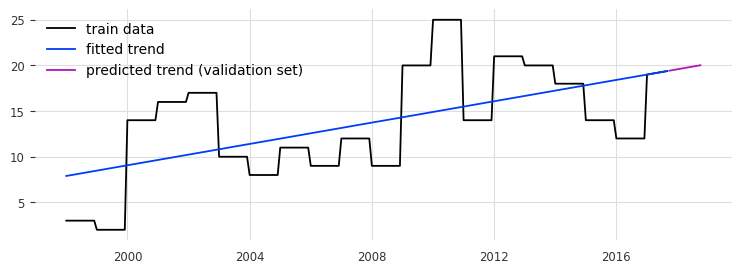

In [206]:
start_date = '2017-01-01'
end_date = '2017-09-01'
dates = pd.date_range(start=start_date, end=end_date, freq='MS')
dates_list_test_end = dates.to_list()

start_date = '2017-10-01'
end_date = '2018-10-01'
dates = pd.date_range(start=start_date, end=end_date, freq='MS')
dates_list_future = dates.to_list()

predicted_val_area_rpa = fit_poly(data.full_train_df['Area_rpa'], data.full_validation_df['Area_rpa'].index, data.full_validation_df['Area_rpa'].values)
predicted_test_1_area_rpa = fit_poly(data.full_train_val_df['Area_rpa'], data.full_test_df['Area_rpa'].dropna().index, data.full_test_df['Area_rpa'].dropna().values)
predicted_test_2_area_rpa = fit_poly(data.full_df['Area_rpa'].dropna(), dates_list_test_end)
predicted_test_area_rpa = pd.concat([predicted_test_1_area_rpa, predicted_test_2_area_rpa])

combined_rpa = pd.concat([data.full_df['Area_rpa'].dropna(), predicted_test_2_area_rpa]).sort_index()
combined_rpa = combined_rpa[~combined_rpa.index.duplicated(keep='first')]
end_date = pd.to_datetime('2017-09-01')
combined_rpa = combined_rpa[combined_rpa.index <= end_date]

combined_rpa_test = combined_rpa[train_size + val_size:]
data.full_df['Area_rpa'] = combined_rpa.values
data.area_df['Area_rpa'] = combined_rpa.values
data.full_test_df['Area_rpa'] = combined_rpa_test.values
data.test_area_df['Area_rpa'] = combined_rpa_test.values

predicted_future_area_rpa = fit_poly(data.full_df['Area_rpa'], dates_list_future)

data.full_df['Area_rpa'] = data.full_df.groupby(data.full_df.index.year)['Area_rpa'].transform('mean')
data.area_df['Area_rpa'] = data.area_df.groupby(data.area_df.index.year)['Area_rpa'].transform('mean')
data.full_test_df['Area_rpa'] = data.full_test_df.groupby(data.full_test_df.index.year)['Area_rpa'].transform('mean')
data.test_area_df['Area_rpa'] = data.test_area_df.groupby(data.test_area_df.index.year)['Area_rpa'].transform('mean')

#### Each year in Area dataset has a constant value of observation, so for each year I will take a mean of the trend I predicted.

In [207]:
validation_x['Area_npa'] = predicted_val_area_npa.values
validation_x['Area_rpa'] = predicted_val_area_rpa.values

validation_x['Area_npa'] =validation_x.groupby(validation_x.index.year)['Area_npa'].transform('mean')
validation_x['Area_rpa'] =validation_x.groupby(validation_x.index.year)['Area_rpa'].transform('mean')

print(validation_x)

             Area_rpa    Area_npa    lag 1    lag 2    lag 3
2011-10-01  18.079053  758.946913  267.000  233.558  240.000
2011-11-01  18.079053  758.946913  266.000  267.000  233.558
2011-12-01  18.079053  758.946913  222.491  266.000  267.000
2012-01-01  18.612086  767.708407  194.248  222.491  266.000
2012-02-01  18.612086  767.708407  168.464  194.248  222.491
2012-03-01  18.612086  767.708407  166.014  168.464  194.248
2012-04-01  18.612086  767.708407  175.802  166.014  168.464
2012-05-01  18.612086  767.708407  184.266  175.802  166.014
2012-06-01  18.612086  767.708407  195.788  184.266  175.802
2012-07-01  18.612086  767.708407  214.601  195.788  184.266
2012-08-01  18.612086  767.708407  249.832  214.601  195.788
2012-09-01  18.612086  767.708407  245.587  249.832  214.601
2012-10-01  18.612086  767.708407  283.000  245.587  249.832
2012-11-01  18.612086  767.708407  259.000  283.000  245.587
2012-12-01  18.612086  767.708407  244.562  259.000  283.000
2013-01-01  19.464937  7

## **SARIMA(X)**

In [208]:
def plot_preds(predictions,
               mape,
               train=data.train_production_df['Production'].values,
               train_idx=data.train_production_df['Production'].index,
               validation=data.val_production_df['Production'].values,
               validation_idx=data.val_production_df['Production'].index):
    plt.plot(train_idx, train, label='train data')
    plt.plot(validation_idx, validation, label='validation data')
    plt.plot(validation_idx, predictions, linestyle='--', label='predictions')
    plt.legend(loc='upper left')
    plt.title(f'MAPE: {mape}%')
    plt.grid(alpha=0.3)
    plt.show()
    

In [209]:
def fit_sarimax(train_series, validation_series, exog_train, exog_valid, season=12, upper=5):
    best_params = (0,1,0,0,1,0,season)
    best_mape = float('inf')
    if exog_train is None:
        print('Starting tuning SARIMA parameters...')
    else:
        print('Starting tuning SARIMAX parameters...')
    for p in range(upper+1):
        for q in range(upper+1):
            for P in range(upper+1):
                for Q in range(upper+1):
                    model = SARIMAX(train_series,
                                    order=(p,1,q),
                                    seasonal_order=(P,1,Q,season),
                                    trend='c',
                                    exog=exog_train).fit()
                    predictions = model.get_prediction(start=validation_series.index[0], end=validation_series.index[-1], exog=exog_valid)
                    predictions = predictions.predicted_mean
                    curr_mape = round(mape(validation_series, predictions)*100, 3)
                    if curr_mape < best_mape:
                        best_mape = curr_mape
                        best_params = (p,1,q,P,1,Q,season)
                        best_preds = predictions
                    print(f'q={q} p={q} P={P} Q={Q} current MAPE={curr_mape}%')
    print('Ended tuning parameters!')
    print(f'Best parameters are:\nq={best_params[0]} d=1 p={best_params[2]} P={best_params[3]} D=1 Q={best_params[5]} best MAPE={best_mape}%')
    
    return best_preds, best_mape

In [210]:
train_series = pd.Series(data=data.train_production_df['Production'], index=data.train_production_df.index)
val_series = pd.Series(data=data.val_production_df['Production'], index=data.val_production_df.index)
predictions_sarima, mape_sarima = fit_sarimax(train_series, val_series, None, None)

Starting tuning SARIMA parameters...
q=0 p=0 P=0 Q=0 current MAPE=58.51%
q=0 p=0 P=0 Q=1 current MAPE=28.356%
q=0 p=0 P=0 Q=2 current MAPE=33.304%
q=0 p=0 P=0 Q=3 current MAPE=41.131%
q=0 p=0 P=0 Q=4 current MAPE=34.69%
q=0 p=0 P=0 Q=5 current MAPE=34.299%
q=0 p=0 P=1 Q=0 current MAPE=42.804%
q=0 p=0 P=1 Q=1 current MAPE=34.643%
q=0 p=0 P=1 Q=2 current MAPE=34.609%
q=0 p=0 P=1 Q=3 current MAPE=40.162%
q=0 p=0 P=1 Q=4 current MAPE=42.143%
q=0 p=0 P=1 Q=5 current MAPE=36.083%
q=0 p=0 P=2 Q=0 current MAPE=42.706%
q=0 p=0 P=2 Q=1 current MAPE=34.618%
q=0 p=0 P=2 Q=2 current MAPE=39.15%
q=0 p=0 P=2 Q=3 current MAPE=36.969%
q=0 p=0 P=2 Q=4 current MAPE=34.589%
q=0 p=0 P=2 Q=5 current MAPE=36.201%
q=0 p=0 P=3 Q=0 current MAPE=48.569%
q=0 p=0 P=3 Q=1 current MAPE=40.202%
q=0 p=0 P=3 Q=2 current MAPE=37.643%
q=0 p=0 P=3 Q=3 current MAPE=36.366%
q=0 p=0 P=3 Q=4 current MAPE=35.087%
q=0 p=0 P=3 Q=5 current MAPE=36.554%
q=0 p=0 P=4 Q=0 current MAPE=39.159%
q=0 p=0 P=4 Q=1 current MAPE=37.777%
q=0 

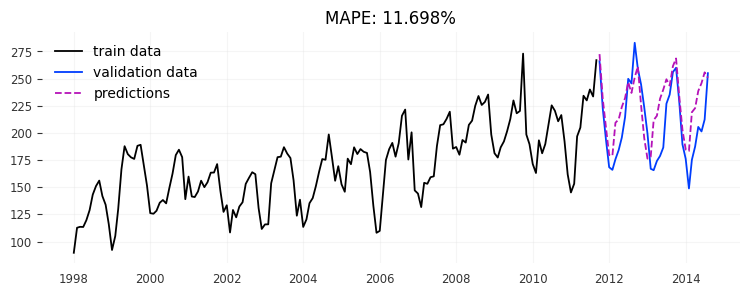

In [211]:
plot_preds(predictions_sarima, mape_sarima)

In [212]:
exog_train = pd.concat([data.full_train_df['Area_npa'], data.full_train_df['Area_rpa']], axis=1)
exog_train.columns = ['Area_npa', 'Area_rpa']

exog_val = pd.concat([predicted_val_area_npa, predicted_val_area_rpa], axis=1)
exog_val.columns = ['Area_npa', 'Area_rpa']

predictions_sarimax, mape_sarimax = fit_sarimax(train_series, val_series, exog_train, exog_val)

Starting tuning SARIMAX parameters...
q=0 p=0 P=0 Q=0 current MAPE=50.969%
q=0 p=0 P=0 Q=1 current MAPE=27.181%
q=0 p=0 P=0 Q=2 current MAPE=32.332%
q=0 p=0 P=0 Q=3 current MAPE=38.541%
q=0 p=0 P=0 Q=4 current MAPE=33.053%
q=0 p=0 P=0 Q=5 current MAPE=34.038%
q=0 p=0 P=1 Q=0 current MAPE=37.981%
q=0 p=0 P=1 Q=1 current MAPE=33.392%
q=0 p=0 P=1 Q=2 current MAPE=33.367%
q=0 p=0 P=1 Q=3 current MAPE=37.048%
q=0 p=0 P=1 Q=4 current MAPE=40.264%
q=0 p=0 P=1 Q=5 current MAPE=35.143%
q=0 p=0 P=2 Q=0 current MAPE=37.928%
q=0 p=0 P=2 Q=1 current MAPE=33.461%
q=0 p=0 P=2 Q=2 current MAPE=37.109%
q=0 p=0 P=2 Q=3 current MAPE=36.811%
q=0 p=0 P=2 Q=4 current MAPE=35.825%
q=0 p=0 P=2 Q=5 current MAPE=34.928%
q=0 p=0 P=3 Q=0 current MAPE=44.375%
q=0 p=0 P=3 Q=1 current MAPE=38.344%
q=0 p=0 P=3 Q=2 current MAPE=34.608%
q=0 p=0 P=3 Q=3 current MAPE=33.75%
q=0 p=0 P=3 Q=4 current MAPE=35.51%
q=0 p=0 P=3 Q=5 current MAPE=35.578%
q=0 p=0 P=4 Q=0 current MAPE=38.87%
q=0 p=0 P=4 Q=1 current MAPE=36.047%
q=0

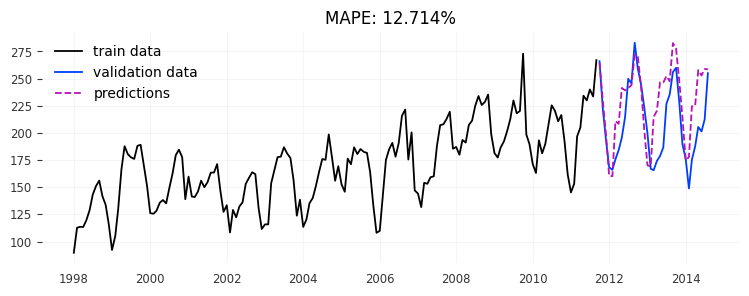

In [213]:
plot_preds(predictions_sarimax, mape_sarimax)

## **ML Regressive Models**

#### I decided to try three models: Support Vector Regression, a type of Support Vector Machine, Random Forest and XGBoost. Since these models are not intially dedicaded for time series forecasting, each will predict production based on 5 features: Area_npa, Area_rpa and three previous lags. The predictions will be made iteratively: since we cannot know the previous values ​​for the future values, the algorithm will be as follows: predict one value based on known three previous lags and predicted Area features, update, predict again. 

##### When I first started working on this project, I used actual known values for forecast and obtained great results. When rewritten algorithm - results became ten times worse, but I guess it is better to use the right approach, because when it comes to predicting we cannot know future values. 

#### To tune hyperparameters for SVR and XGBoost I used GridSearch.

## **Support Vector Regression (SVR)**

In [283]:
def fit_svr(train_x, train_y, validation_x, validation_y):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    train_y = train_y.to_numpy().reshape(-1, 1)
    validation_y = validation_y.to_numpy().reshape(-1, 1)

    train_x = scaler_x.fit_transform(train_x)
    validation_x = scaler_x.transform(validation_x)

    train_y = scaler_y.fit_transform(train_y)
    val_y = scaler_y.transform(validation_y)

    print('Choosing best kernel for SVR...')

    best_score = float('-inf')
    for k in ['linear','poly','rbf','sigmoid']:
        clf = SVR(kernel=k)
        clf.fit(train_x, train_y)
        confidence = clf.score(train_x, train_y)
        print(f'kernel: {k} confidence: {confidence}')
        if confidence > best_score:
            best_score = confidence
            best_kernel = k
    print(f'The best kernel is {best_kernel} with confidence {best_score}')
    print('Starting tuning hyperparameters for SVR...')

    C = [1] + list(range(10, 101, 10))
    epsilon = [0.01] + [x/100 for x in range(5, 101, 5)]

    param_grid = {
        'C': C,
        'epsilon': epsilon,
        'gamma': ['auto', 'scale']
    }

    model = SVR()
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_absolute_error')
    grid_search.fit(train_x, train_y)
    print(f'best hyperparameters: {grid_search.best_params_}')

    model = SVR(kernel=best_kernel,
                C=grid_search.best_params_['C'],
                gamma=grid_search.best_params_['gamma'],
                epsilon=grid_search.best_params_['epsilon'])
    
    model.fit(train_x, train_y)
    print(f'The score of the SVR Models is: {model.score(train_x, train_y)}')

    validation_x_temp = validation_x[0:1, :]
    
    predictions = []
    for i in range(len(validation_x)):
        prediction = model.predict(validation_x_temp)
        prediction = prediction[0]
        predictions.append(prediction)
        previous_step = validation_x_temp
        if i < len(validation_x)-1:
            next_step = list()
            area_npa = validation_x[i+1, 1]
            area_rpa = validation_x[i+1, 0]
            next_step = [area_rpa, area_npa, prediction]
            lags = previous_step[0, 2:-1]
            next_step.extend(lags)
            validation_x_temp = np.array([next_step])

    predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
    val_y = scaler_y.inverse_transform(np.array(val_y).reshape(-1, 1))

    svr_mape = round(mape(val_y, predictions)*100, 3)
    print(f'MAPE value of the SVR Model is: {svr_mape}%')

    return predictions.reshape(-1), svr_mape

Choosing best kernel for SVR...
kernel: linear confidence: 0.7821711099758358
kernel: poly confidence: 0.7393992738230886
kernel: rbf confidence: 0.8451328840506322
kernel: sigmoid confidence: -919.2163129449661
The best kernel is rbf with confidence 0.8451328840506322
Starting tuning hyperparameters for SVR...
best hyperparameters: {'C': 1, 'epsilon': 0.01, 'gamma': 'auto'}
The score of the SVR Models is: 0.7903354762783263
MAPE value of the SVR Model is: 16.635%


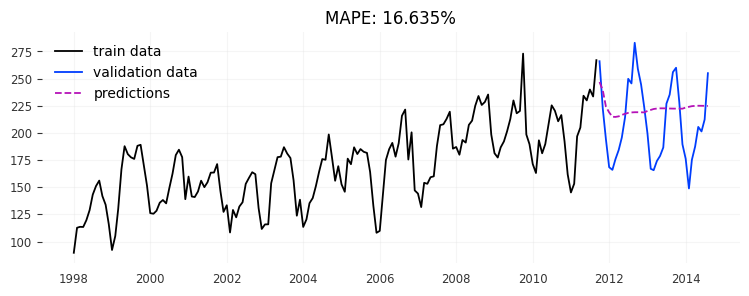

In [284]:
predictions_svr, mape_svr = fit_svr(train_x, train_y, validation_x, validation_y)
predictions_svr = predictions_svr.reshape(-1)

plot_preds(predictions_svr, mape_svr)

## **Random Forest**

In [285]:
def fit_rf(train_x, train_y, validation_x, validation_y):
    print('Starting tuning hyperparameters for Random Forest...')
    best_mape = float('inf')
    for est in range(100, 1101, 100):
        model = RandomForestRegressor(n_estimators=est, random_state=1).fit(train_x, train_y)

        validation_x_temp = validation_x.iloc[[0]]
        predictions = []
        for i in range(len(validation_x)):
            prediction = model.predict(validation_x_temp)
            prediction = prediction[0]
            predictions.append(prediction)
            previous_step = validation_x_temp
            if i < len(validation_x)-1:
                next_index = validation_x_temp.index[0] + pd.DateOffset(months=1)
                next_step = list()
                area_npa = validation_x.iloc[i+1, validation_x.columns.get_loc('Area_npa')]
                area_rpa = validation_x.iloc[i+1, validation_x.columns.get_loc('Area_rpa')]
                next_step = [area_rpa, area_npa, prediction]
                lags = list(previous_step.iloc[[0]].values.reshape(-1))
                next_step.extend(lags[2:-1])
                column_names = validation_x_temp.columns
                validation_x_temp = pd.DataFrame([next_step], columns=column_names, index=[next_index])

        rf_mape = round(mape(validation_y, predictions)*100, 3)
        print(f'Number of estimators: {est} MAPE: {rf_mape}%')
        if rf_mape < best_mape:
            best_mape = rf_mape
            best_estimator = est
            best_preds = predictions
    print(f'The best number of estimators: {best_estimator} the best MAPE: {best_mape}%')
    return best_preds, best_mape


Starting tuning hyperparameters for Random Forest...
Number of estimators: 100 MAPE: 23.947%
Number of estimators: 200 MAPE: 23.791%
Number of estimators: 300 MAPE: 23.776%
Number of estimators: 400 MAPE: 23.477%
Number of estimators: 500 MAPE: 23.653%
Number of estimators: 600 MAPE: 23.584%
Number of estimators: 700 MAPE: 23.688%
Number of estimators: 800 MAPE: 23.821%
Number of estimators: 900 MAPE: 23.774%
Number of estimators: 1000 MAPE: 23.766%
Number of estimators: 1100 MAPE: 23.761%
The best number of estimators: 400 the best MAPE: 23.477%


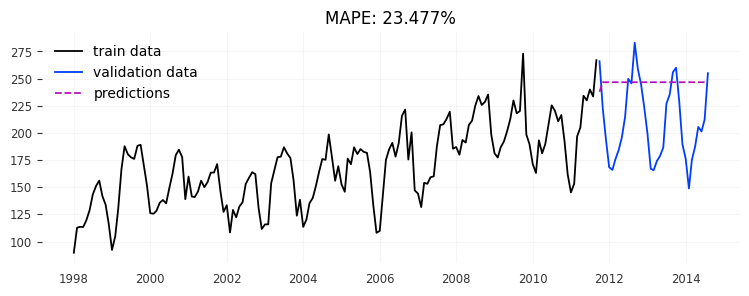

In [286]:
predictions_rf, mape_rf = fit_rf(train_x, train_y, validation_x, validation_y)

plot_preds(predictions_rf, mape_rf)

## **XGBoost**

In [287]:
def fit_xgboost(train_x, train_y, validation_x, validation_y):
    print('Starting tuning hyperparameters for XGBoost...')
    cv_split = TimeSeriesSplit(n_splits=5)
    model = XGBRegressor()
    parameters = {
        "max_depth": [3, 4, 6, 5, 10],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
        "n_estimators": [x for x in range(100, 1001, 100)],
        "colsample_bytree": [0.3, 0.5, 0.7]
    }

    grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
    grid_search.fit(train_x, train_y)
    print(f'best hyperparameters: {grid_search.best_params_}')

    model = XGBRegressor(max_depth=grid_search.best_params_['max_depth'],
                         learning_rate=grid_search.best_params_['learning_rate'],
                         n_estimators=grid_search.best_params_['n_estimators'],
                         colsample_bytree=grid_search.best_params_['colsample_bytree'])
    
    model.fit(train_x, train_y)
    print(f'The score of the XGBoost Models is: {model.score(train_x, train_y)}')

    validation_x_temp = validation_x.iloc[[0]]
    predictions = []
    for i in range(len(validation_x)):
        prediction = model.predict(validation_x_temp)
        prediction = prediction[0]
        predictions.append(prediction)
        previous_step = validation_x_temp
        if i < len(validation_x)-1:
            next_index = validation_x_temp.index[0] + pd.DateOffset(months=1)
            next_step = list()
            area_npa = validation_x.iloc[i+1, validation_x.columns.get_loc('Area_npa')]
            area_rpa = validation_x.iloc[i+1, validation_x.columns.get_loc('Area_rpa')]
            next_step = [area_rpa, area_npa, prediction]
            lags = list(previous_step.iloc[[0]].values.reshape(-1))
            next_step.extend(lags[2:-1])
            column_names = validation_x_temp.columns
            validation_x_temp = pd.DataFrame([next_step], columns=column_names, index=[next_index])

    # predictions = model.predict(validation_x)
    xgboost_mape = round(mape(validation_y, predictions)*100, 3)
    print(f'MAPE value of the XGBoost Model is: {xgboost_mape}%')
    return predictions, xgboost_mape

Starting tuning hyperparameters for XGBoost...
best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
The score of the XGBoost Models is: 0.9257603038382867
MAPE value of the XGBoost Model is: 20.809%


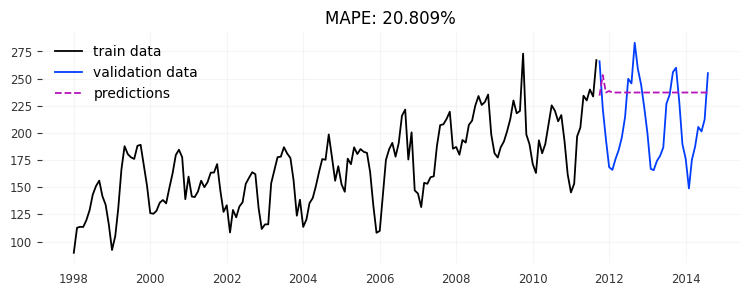

In [288]:
predictions_xgboost, mape_xgboost = fit_xgboost(train_x, train_y, validation_x, validation_y)

plot_preds(predictions_xgboost, mape_xgboost)

#### Results are quite bad, we can see that as time goes they average out, which is generally not surprising. Still some of the results (generated by Random Forest and XGBoost) are quite strange, and I did not found the explanation for them.

## **FB Prophet**

In [289]:
data.full_train_df

,Month,Production,Rainfall,Area_ma,Area_npa,Area_rpa,Area_ma_new,Time
1998-01-01,1,89.690,157.849442,506.0,562.0,3.0,398.500000,0
1998-02-01,2,112.724,159.374471,506.0,562.0,3.0,398.500000,1
1998-03-01,3,113.573,118.394494,506.0,562.0,3.0,398.500000,2
1998-04-01,4,113.454,99.763690,506.0,562.0,3.0,398.500000,3
1998-05-01,5,119.671,182.705310,506.0,562.0,3.0,398.500000,4
...,...,...,...,...,...,...,...,...
2011-05-01,5,234.232,174.401459,629.0,743.0,14.0,423.669231,160
2011-06-01,6,229.944,146.843811,629.0,743.0,14.0,423.669231,161
2011-07-01,7,240.000,120.403273,629.0,743.0,14.0,423.669231,162
2011-08-01,8,233.558,236.020045,629.0,743.0,14.0,423.669231,163


#### Since the FB Prophet model is made specifically for time series forecasting, I have decided to omit previous lags features to simplfy the task a little. Still we will see that the results compared to other models are much better.

In [290]:
def fit_fbprophet():
    logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

    print('Starting tuning hyperparameters for FB Prophet...')

    params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
    grid = ParameterGrid(params_grid)

    best_mape = float('inf')

    df_train_temp = data.full_train_df.reset_index()
    ptrain = pd.DataFrame()
    ptrain["ds"] = pd.to_datetime(df_train_temp['index'])
    ptrain["y"] = df_train_temp['Production']
    ptrain["area_rpa"] = df_train_temp['Area_rpa']
    ptrain["area_npa"] = df_train_temp['Area_npa']
    floor_value = ptrain['y'].min()
    cap_value = ptrain['y'].max() + (ptrain['y'].max() * 0.2)
    ptrain['floor'] = floor_value
    ptrain['cap'] = cap_value

    for params in grid:
        model = Prophet(changepoint_prior_scale = params['changepoint_prior_scale'],
                            n_changepoints = params['n_changepoints'],
                            seasonality_mode = params['seasonality_mode'],
                            yearly_seasonality = True,
                            interval_width=0.95)

        model.add_regressor('area_rpa')
        model.add_regressor('area_npa')

        model.fit(ptrain)

        pvalidation = model.make_future_dataframe(periods=len(data.full_validation_df), include_history=False, freq="m")
        df_val_temp = data.full_validation_df.reset_index()
        pvalidation["area_rpa"] = predicted_val_area_rpa.values
        pvalidation["area_npa"] = predicted_val_area_npa.values
        pvalidation['floor'] = floor_value
        pvalidation['cap'] = cap_value

        predictions = model.predict(pvalidation)

        fb_mape = mape(data.full_validation_df['Production'], predictions['yhat']) * 100
        if fb_mape < best_mape:
            best_mape = fb_mape
            best_params = params
            best_preds = predictions

    print(f'best hyperparameters: {best_params}')
    print(f'MAPE for FB Prophet model: {round(best_mape, 3)}%')

    model = Prophet(changepoint_prior_scale = best_params['changepoint_prior_scale'],
                            n_changepoints = best_params['n_changepoints'],
                            seasonality_mode = best_params['seasonality_mode'],
                            yearly_seasonality = True,
                            interval_width=0.95)

    model.add_regressor('area_rpa')
    model.add_regressor('area_npa')

    model.fit(ptrain)

    pvalidation = model.make_future_dataframe(periods=len(data.full_validation_df), include_history=False, freq="m")
    pvalidation["area_rpa"] = predicted_val_area_rpa.values
    pvalidation["area_npa"] = predicted_val_area_npa.values
    pvalidation['floor'] = floor_value
    pvalidation['cap'] = cap_value

    forecast = model.predict(pvalidation)
    model.plot(forecast)
    model.plot_components(forecast)

    return best_preds['yhat'], round(best_mape, 3)


Starting tuning hyperparameters for FB Prophet...
best hyperparameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
MAPE for FB Prophet model: 10.278%


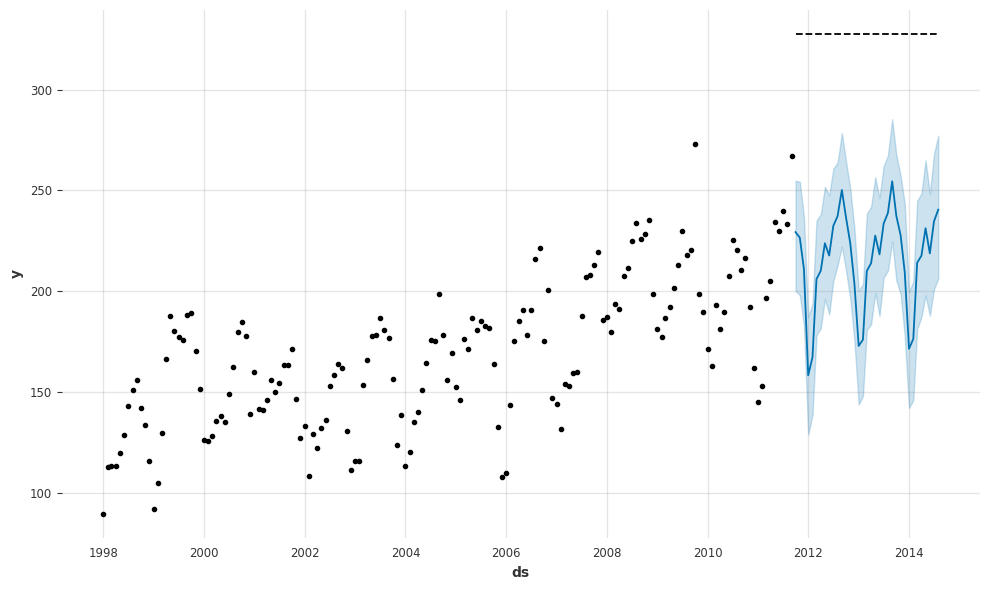

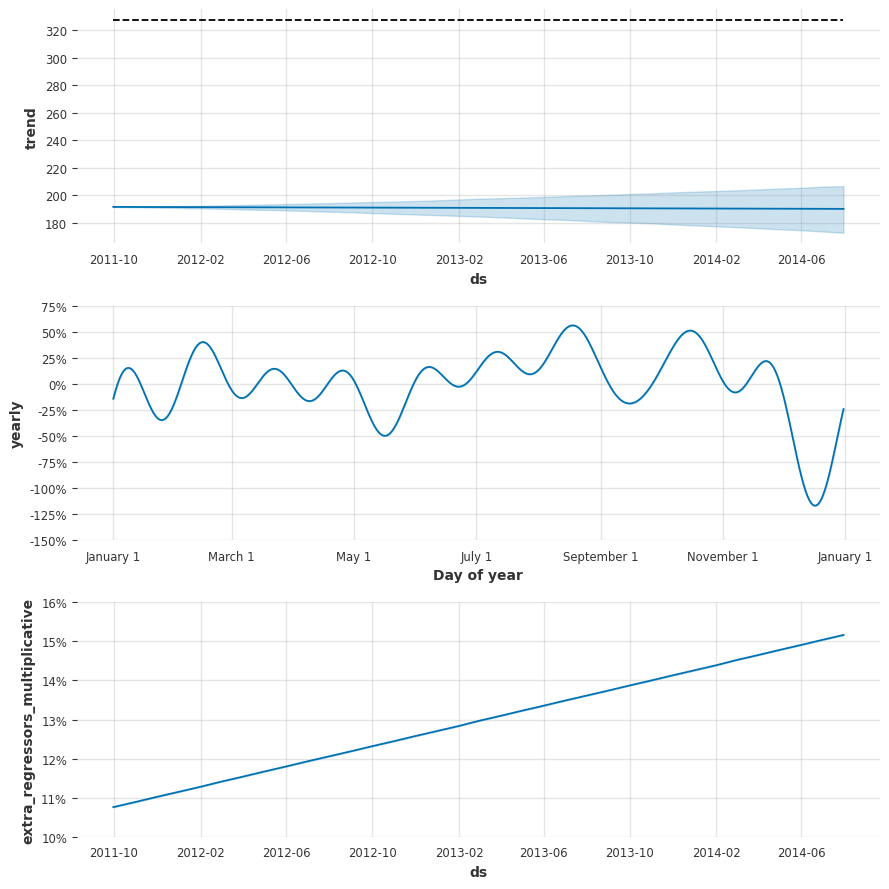

In [291]:
predictions_fb, mape_fb = fit_fbprophet()

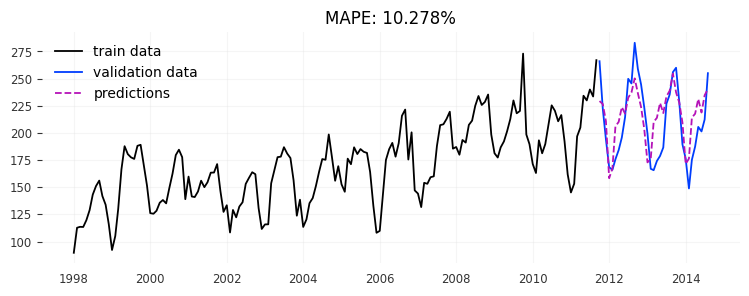

In [292]:
plot_preds(predictions_fb, mape_fb)

## **Deep Learning Approaches**

#### In this part I tried to tune hyperparameters for LSTM and GRU, which, I guess, made results slightly better. Again, when I started working on this project, I updated lags iteratively, but used actual values of Area_npa and Area_rpa, and results were way better. In this final version LSTM and GRU use predicted results of Area_npa and Area_rpa and also update previous lags on each step. 

#### As for CNN, it requires a more complex reshaping and I decided to omit previous lags features to simlify the task. Well, It performed rather bad, and I guess if I tuned hyperparameters I would obtained slightly better results. I only tried to train it with different kernel size and t parameter. Not surprisingly, 3 was the best value for both parameters.

## **1. Long Short-Term Memory (LSTM) Neural Network**

#### LSTM is kind of RNN algorithm and extension of the eralier RNNs. It has long-term memory and uses it to learn patterns in data sequences.

In [293]:
def create_model(neurons=20, dropout_rate=0.2, optimizer='Adam', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(1, 5)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    optimizer_functions = {
        'RMSprop': lambda lr: RMSprop(learning_rate=lr),
        'Adadelta': lambda lr: Adadelta(learning_rate=lr),
        'Adam': lambda lr: Adam(learning_rate=lr),
        'Nadam': lambda lr: Nadam(learning_rate=lr)
    }

    optimizer_func = optimizer_functions.get(optimizer)
    opt = optimizer_func(learning_rate)
    model.compile(loss='mean_squared_error', optimizer=opt)
    
    return model


In [294]:
def fit_lstm(train_x, train_y, validation_x, validation_y):
    print('Starting tuning LSTM hyperparameters...')

    model = KerasRegressor(build_fn=create_model, verbose=1, neurons=20, dropout_rate=0.2, optimizer='Adam', learning_rate=0.001)

    param_grid = {
        'neurons': [20, 30, 40],
        'dropout_rate': [0.2, 0.3],
        'optimizer': ['Adadelta', 'Adam', 'RMSprop', 'Nadam'],
        'batch_size': [64],
        'epochs': [500],
        'learning_rate': [0.001, 0.01, 0.05, 0.1]
    }

    optimizer_functions = {
        'RMSprop': lambda lr: RMSprop(learning_rate=lr),
        'Adadelta': lambda lr: Adadelta(learning_rate=lr),
        'Adam': lambda lr: Adam(learning_rate=lr),
        'Nadam': lambda lr: Nadam(learning_rate=lr)
    }

    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    train_y = train_y.to_numpy().reshape(-1, 1)
    validation_y = validation_y.to_numpy().reshape(-1, 1)
    train_x = scaler_x.fit_transform(train_x)
    validation_x = scaler_x.transform(validation_x)
    train_y = scaler_y.fit_transform(train_y)
    validation_y = scaler_y.transform(validation_y)

    train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
    validation_x = validation_x.reshape((validation_x.shape[0], 1, validation_x.shape[1]))

    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(train_x, train_y)

    print(f'Best hyperparameters for LSTM: {grid_result.best_params_}')
    print(f'Best score for LSTM: {grid_result.best_score_}')

    print('Starting fitting LSTM...')
    model = Sequential()
    model.add(LSTM(grid_result.best_params_['neurons'], input_shape=(train_x.shape[1], train_x.shape[2])))
    model.add(Dropout(grid_result.best_params_['dropout_rate']))
    model.add(Dense(5, activation='relu'))
    optimizer_func = optimizer_functions.get(grid_result.best_params_['optimizer'])
    opt = optimizer_func(grid_result.best_params_['learning_rate'])
    model.compile(loss='mean_squared_error', optimizer=opt)

    history = model.fit(train_x, train_y, 
                        epochs=500, batch_size=64, 
                        verbose=2, shuffle=False)

    plt.plot(history.history['loss'], label='train')
    plt.legend()
    plt.show()

    validation_x_temp = validation_x[0:1, :, :]
    predictions = []
    for i in range(len(validation_x)):
        prediction = model.predict(validation_x_temp)
        prediction = prediction.reshape(-1)[0]
        predictions.append(prediction)
        previous_step = validation_x_temp
        if i < len(validation_x):
            rainfall_area = validation_x[i, 0, :2]
            next_step = np.append(rainfall_area, prediction)
            lags = previous_step[0, 0, 2:-1]
            next_step = np.append(next_step, lags)
            validation_x_temp = np.array([[next_step]])
            previous_step = next_step

    predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
    validation_y = scaler_y.inverse_transform(np.array(validation_y).reshape(-1, 1))
    mape_lstm = mape(validation_y, predictions) * 100
    return predictions.reshape(-1), round(mape_lstm, 3)

Starting tuning LSTM hyperparameters...
Epoch 1/500
3/3 [==============================] - 2s 6ms/step - loss: 0.2909
Epoch 2/500
3/3 [==============================] - 0s 4ms/step - loss: 0.2659
Epoch 3/500
3/3 [==============================] - 0s 5ms/step - loss: 0.2402
Epoch 4/500
3/3 [==============================] - 0s 4ms/step - loss: 0.2189
Epoch 5/500
3/3 [==============================] - 0s 6ms/step - loss: 0.1933
Epoch 6/500
3/3 [==============================] - 0s 6ms/step - loss: 0.1747
Epoch 7/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1571
Epoch 8/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1362
Epoch 9/500
3/3 [==============================] - 0s 6ms/step - loss: 0.1194
Epoch 10/500
3/3 [==============================] - 0s 7ms/step - loss: 0.1059
Epoch 11/500
3/3 [==============================] - 0s 6ms/step - loss: 0.0923
Epoch 12/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0768
Epoch 13/500
3/3 [===

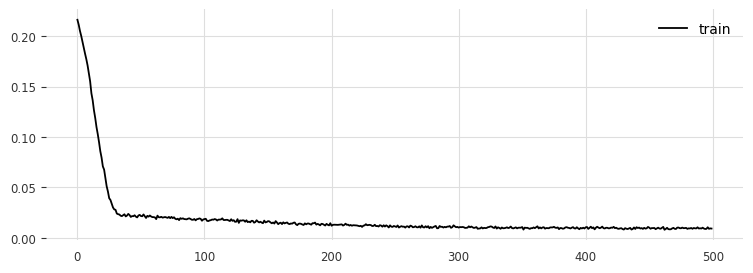

1/1 [==============================] - 0s 25ms/step


In [295]:
predictions_lstm, mape_lstm = fit_lstm(train_x, train_y, validation_x, validation_y)

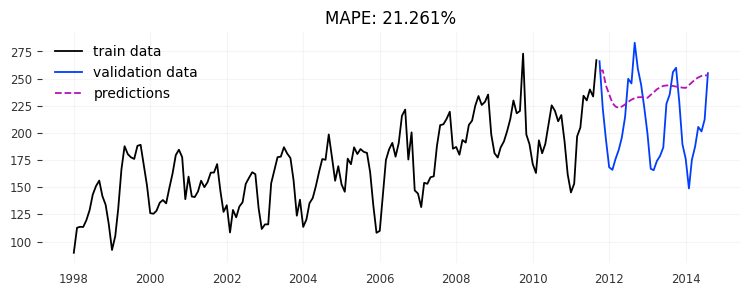

In [296]:
plot_preds(predictions_lstm, mape_lstm)

## **2. Gated Recurrent Unit (GRU)**

#### As the second DL approach I have chosen Gated Recurrent Unit - RNN wich can be considered as a variant of LSTM. We can see that the plotted line (predictions) looks pretty similar to LSTM, but the accuracy of the model is 4% better.

In [297]:
def fit_gru(train_x, train_y, validation_x, validation_y):
    print('Starting tuning GRU hyperparameters...')

    model = KerasRegressor(build_fn=create_model, verbose=1, neurons=20, dropout_rate=0.2, optimizer='Adam', learning_rate=0.001)

    param_grid = {
        'neurons': [20, 30, 40],
        'dropout_rate': [0.2, 0.3],
        'optimizer': ['Adadelta', 'Adam', 'RMSprop', 'Nadam'],
        'batch_size': [64],
        'epochs': [500],
        'learning_rate': [0.001, 0.01, 0.05, 0.1]
    }

    optimizer_functions = {
        'RMSprop': lambda lr: RMSprop(learning_rate=lr),
        'Adadelta': lambda lr: Adadelta(learning_rate=lr),
        'Adam': lambda lr: Adam(learning_rate=lr),
        'Nadam': lambda lr: Nadam(learning_rate=lr)
    }

    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    train_y = train_y.to_numpy().reshape(-1, 1)
    validation_y = validation_y.to_numpy().reshape(-1, 1)
    train_x = scaler_x.fit_transform(train_x)
    validation_x = scaler_x.transform(validation_x)
    train_y = scaler_y.fit_transform(train_y)
    validation_y = scaler_y.transform(validation_y)

    train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
    validation_x = validation_x.reshape((validation_x.shape[0], 1, validation_x.shape[1]))

    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(train_x, train_y)

    print(f'Best hyperparameters for GRU: {grid_result.best_params_}')
    print(f'Best score for GRU: {grid_result.best_score_}')

    print('Starting fitting GRU...')
    model = Sequential()
    model.add(GRU(grid_result.best_params_['neurons'], input_shape=(train_x.shape[1], train_x.shape[2])))
    model.add(Dropout(grid_result.best_params_['dropout_rate']))
    model.add(Dense(5, activation='relu'))
    optimizer_func = optimizer_functions.get(grid_result.best_params_['optimizer'])
    opt = optimizer_func(grid_result.best_params_['learning_rate'])
    model.compile(loss='mean_squared_error', optimizer=opt)

    history = model.fit(train_x, train_y, 
                        epochs=500, batch_size=64, 
                        verbose=2, shuffle=False)

    plt.plot(history.history['loss'], label='train')
    plt.legend()
    plt.show()

    validation_x_temp = validation_x[0:1, :, :]
    predictions = []
    for i in range(len(validation_x)):
        prediction = model.predict(validation_x_temp)
        prediction = prediction.reshape(-1)[0]
        predictions.append(prediction)
        previous_step = validation_x_temp
        if i < len(validation_x):
            rainfall_area = validation_x[i, 0, :2]
            next_step = np.append(rainfall_area, prediction)
            lags = previous_step[0, 0, 2:-1]
            next_step = np.append(next_step, lags)
            validation_x_temp = np.array([[next_step]])
            previous_step = next_step

    predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
    validation_y = scaler_y.inverse_transform(np.array(validation_y).reshape(-1, 1))
    mape_gru = mape(validation_y, predictions) * 100
    return predictions.reshape(-1), round(mape_gru, 3)

Starting tuning GRU hyperparameters...
Epoch 1/500
3/3 [==============================] - 2s 5ms/step - loss: 0.2201
Epoch 2/500
3/3 [==============================] - 0s 5ms/step - loss: 0.2008
Epoch 3/500
3/3 [==============================] - 0s 6ms/step - loss: 0.1816
Epoch 4/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1610
Epoch 5/500
3/3 [==============================] - 0s 7ms/step - loss: 0.1476
Epoch 6/500
3/3 [==============================] - 0s 7ms/step - loss: 0.1320
Epoch 7/500
3/3 [==============================] - 0s 6ms/step - loss: 0.1193
Epoch 8/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1060
Epoch 9/500
3/3 [==============================] - 0s 3ms/step - loss: 0.0940
Epoch 10/500
3/3 [==============================] - 0s 3ms/step - loss: 0.0859
Epoch 11/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0725
Epoch 12/500
3/3 [==============================] - 0s 7ms/step - loss: 0.0660
Epoch 13/500
3/3 [====

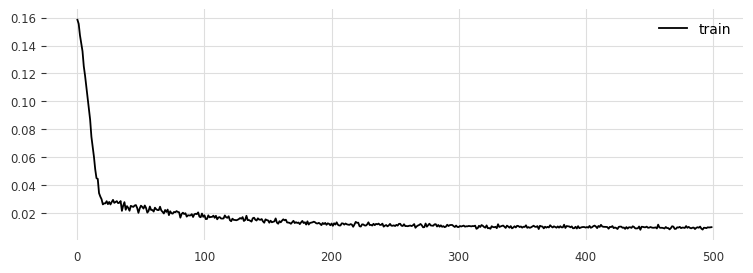

1/1 [==============================] - 0s 30ms/step


In [323]:
predictions_gru, mape_gru = fit_gru(train_x, train_y, validation_x, validation_y)

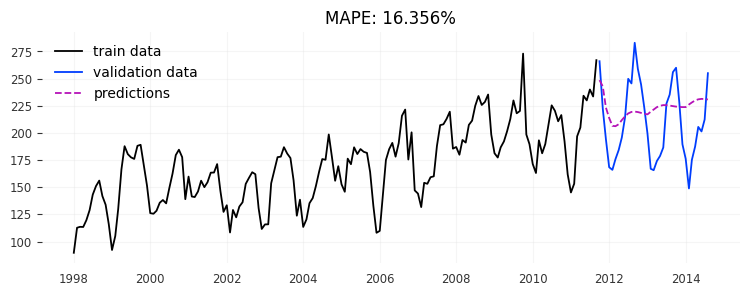

In [325]:
plot_preds(predictions_gru, mape_gru)

## **2. Convolutional Neural Network (CNN)**

#### A Convolutional Neural Network is a type of deep learning algorithm which applies convolutional layers to extract features and patterns from data.

In [328]:
def fit_cnn(train_x, train_y, validation_x, validation_y):   
    print('Starting tuning CNN hyperparameters...')

    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    train_y = train_y.to_numpy().reshape(-1, 1)
    validation_y = validation_y.to_numpy().reshape(-1, 1)
    train_x = scaler_x.fit_transform(train_x)
    validation_x = scaler_x.transform(validation_x)
    train_y = scaler_y.fit_transform(train_y)
    validation_y = scaler_y.transform(validation_y)

    t = 3
    features = 2
    total_samples = len(train_x) - t + 1
    reshaped_data = np.zeros((total_samples, t, features))
    for i in range(total_samples):
        reshaped_data[i] = train_x[i:i+t, :]
    train_x = reshaped_data

    total_samples = len(validation_x) - t + 1
    reshaped_data = np.zeros((total_samples, t, features))
    for i in range(total_samples):
        reshaped_data[i] = validation_x[i:i+t, :]
    validation_x = reshaped_data

    train_y = train_y[t-1:]
    validation_y = validation_y[t-1:]  

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                        input_shape=(t, features)))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    history = model.fit(train_x, train_y, 
                            epochs=500, batch_size=64, 
                            verbose=0, shuffle=False)

    plt.plot(history.history['loss'][1:], label='train')
    plt.legend()
    plt.show()

    predictions = model.predict(validation_x)

    predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
    validation_y = scaler_y.inverse_transform(np.array(validation_y).reshape(-1, 1))
    mape_cnn = mape(validation_y, predictions) * 100
    return predictions.reshape(-1), round(mape_cnn, 3)

Starting tuning CNN hyperparameters...


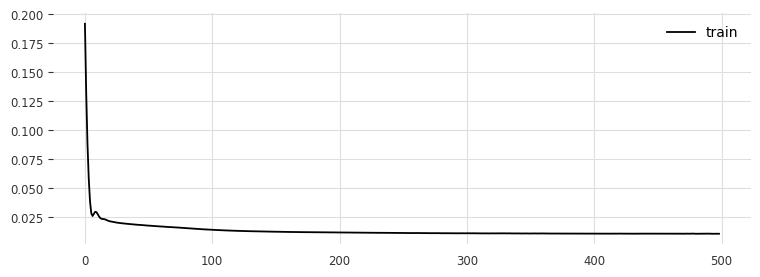

2/2 [==============================] - 0s 4ms/step


In [331]:
train_x_cnn = train_x.drop(columns=['lag 1','lag 2','lag 3'])
validation_x_cnn = validation_x.drop(columns=['lag 1','lag 2','lag 3'])

predictions_cnn, mape_cnn = fit_cnn(train_x_cnn, train_y, validation_x_cnn, validation_y)

#### Well, it definitely captured something, but it is hard to explain what exactly)))

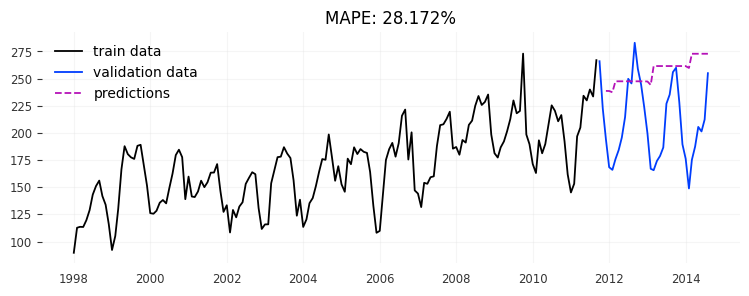

In [332]:
plt.plot(data.train_production_df['Production'], label='train data')
plt.plot(data.val_production_df['Production'], label='validation data')
plt.plot(data.val_production_df['Production'].index[2:], predictions_cnn, linestyle='--', label='predictions')
plt.legend(loc='upper left')
plt.title(f'MAPE: {mape_cnn}%')
plt.grid(alpha=0.3)
plt.show()
    

## **Introducing Fourier terms into ARIMA model**

#### Here I will introduce Fourier terms into ARIMA model, it should help to better capture seasonal patterns. I first tried different amount of terms (up to 15), but result were all the same, so I stopped on 5. Below are results.

In [303]:
def fourier_terms(train_len, season, num_terms):
    terms = []
    for i in range(1, num_terms + 1):
        terms.append(np.sin(2 * np.pi * i * train_len / season))
        terms.append(np.cos(2 * np.pi * i * train_len / season))
    return np.column_stack(terms)

In [304]:
def fit_fourier_arima(train_y, validation_y, season, terms, max_p=5, max_q=5, max_P=5, max_Q=5, stepwise=True, info_criterion='aic'):

    f_terms = fourier_terms(len(train_y), season, terms)

    model = auto_arima(train_y,
                       exogenous=f_terms[:len(train_x)],
                       seasonal=True,
                       suppress_warnings=True,
                       max_p=max_p,
                       max_q=max_q,
                       max_d=1,
                       max_P=max_P,
                       max_Q=max_Q,
                       max_D=1,
                       stepwise=stepwise,
                       info_criterion=info_criterion)
    
    model.fit(train_y, exogenous=f_terms[:len(train_y)])

    forecast_steps = len(validation_y)
    forecast_exog = fourier_terms(np.arange(len(train_y), len(train_y) + forecast_steps), season, terms)

    forecast_df = pd.DataFrame(forecast_exog, columns=[f'fourier_{i+1}' for i in range(terms * 2)])
    predictions = model.predict(n_periods=forecast_steps, exogenous=forecast_df)
    fourier_mape = mape(validation_y, predictions) * 100

    return predictions, round(fourier_mape, 3)

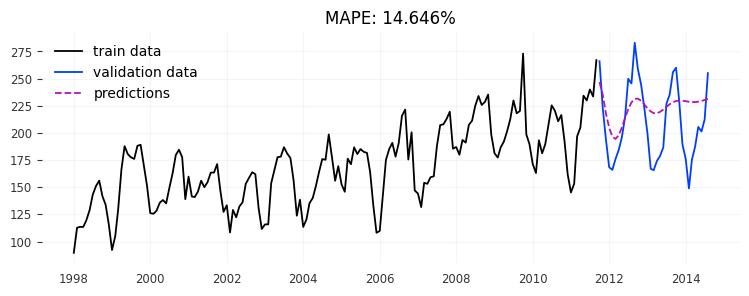

In [305]:
predictions_fourier_arima, mape_fourier_arima = fit_fourier_arima(train_y, validation_y, 12, 5)
plot_preds(predictions_fourier_arima, mape_fourier_arima)

## **Choosing the best model**

#### Now I will choose three models that performed the best, train them on validation+train dataset and after after again choose the best one and make a forecast for the next 12 months.

In [333]:
models = ['SARIMA', 'SARIMAX', 'SVR', 'RF', 'XGBoost', 'FB Prophet', 'LSTM', 'GRU', 'CNN', 'ARIMA with Fourier']
mapes = [mape_sarima, mape_sarimax, mape_svr, mape_rf, mape_xgboost, mape_fb, mape_lstm, mape_gru, mape_cnn, mape_fourier_arima]

models = pd.DataFrame({'model': models, 'MAPE': mapes})
models

,model,MAPE
0,SARIMA,11.698
1,SARIMAX,12.714
2,SVR,16.635
3,RF,23.477
4,XGBoost,20.809
5,FB Prophet,10.278
6,LSTM,21.261
7,GRU,16.356
8,CNN,28.172
9,ARIMA with Fourier,14.646


#### We can see that the best performance showed SARIMA(X), FB Prophet and ARIMA with Fourier terms. So lets train them again on an expanded dataset and see the results.

The MAPE for SARIMA with parameters (5,1,5,2,1,0) is 20.034%


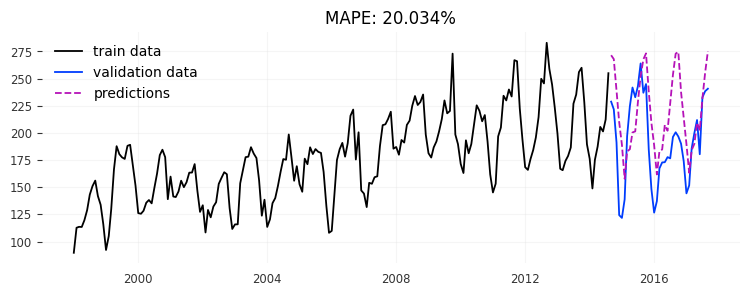

In [309]:
model = SARIMAX(data.full_train_val_df['Production'],
                order=(5,1,5),
                seasonal_order=(2,1,0,12),
                trend='c').fit()
predictions_new_sarima = model.get_prediction(start=data.full_test_df.index[0], end=data.full_test_df.index[-1])
predictions_new_sarima = predictions_new_sarima.predicted_mean
sarima_new_mape = round(mape(data.full_test_df['Production'], predictions_new_sarima)*100, 3)

print(f'The MAPE for SARIMA with parameters (5,1,5,2,1,0) is {sarima_new_mape}%')
plot_preds(predictions_new_sarima,
           sarima_new_mape,
           data.full_train_val_df['Production'].values,
           data.full_train_val_df['Production'].index,
           data.full_test_df['Production'].values,
           data.full_test_df['Production'].index)

In [310]:
def predict_fb(train, regressor_rpa_train, regressor_npa_train, regressor_rpa_val, regressor_npa_val, validation=None):
    ptrain = pd.DataFrame()
    ptrain["ds"] = pd.to_datetime(train.index)
    ptrain["y"] = train.values
    ptrain["area_rpa"] = regressor_rpa_train.values
    ptrain["area_npa"] = regressor_npa_train.values
    floor_value = ptrain['y'].min()
    cap_value = ptrain['y'].max() + (ptrain['y'].max() * 0.2)
    ptrain['floor'] = floor_value
    ptrain['cap'] = cap_value

    model = Prophet(changepoint_prior_scale=0.5,
                            n_changepoints=100,
                            seasonality_mode='multiplicative',
                            yearly_seasonality = True,
                            interval_width=0.95)

    model.add_regressor('area_rpa')
    model.add_regressor('area_npa')

    model.fit(ptrain)

    pvalidation = model.make_future_dataframe(periods=len(regressor_npa_val), include_history=False, freq="m")
    pvalidation["area_rpa"] = regressor_rpa_val.values
    pvalidation["area_npa"] = regressor_npa_val.values
    pvalidation['floor'] = floor_value
    pvalidation['cap'] = cap_value

    predictions_new_fb = model.predict(pvalidation)
    if validation is not None:
        fb_new_mape = mape(validation, predictions_new_fb['yhat']) * 100
        fb_new_mape = round(fb_new_mape, 3)
        print(f'The MAPE for FBProphet model with parameters: changepoint_prior_scale=0.5, n_changepoints=100, seasonality_mode=multiplicative is {fb_new_mape}%')

    model.plot(predictions_new_fb)
    model.plot_components(predictions_new_fb)

    if validation is not None:
        return predictions_new_fb['yhat'], fb_new_mape
    
    return predictions_new_fb['yhat']

The MAPE for FBProphet model with parameters: changepoint_prior_scale=0.5, n_changepoints=100, seasonality_mode=multiplicative is 15.28%


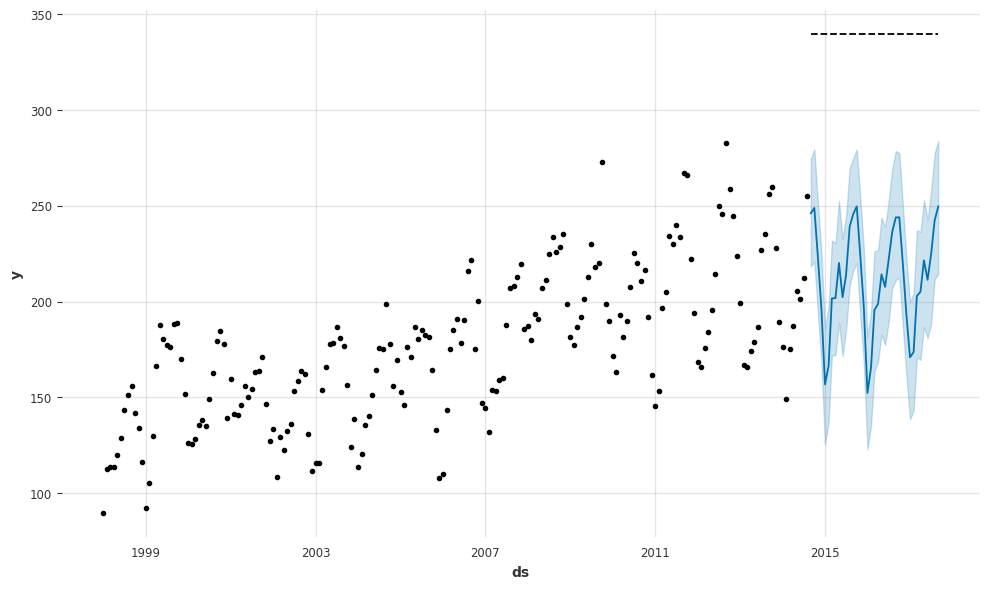

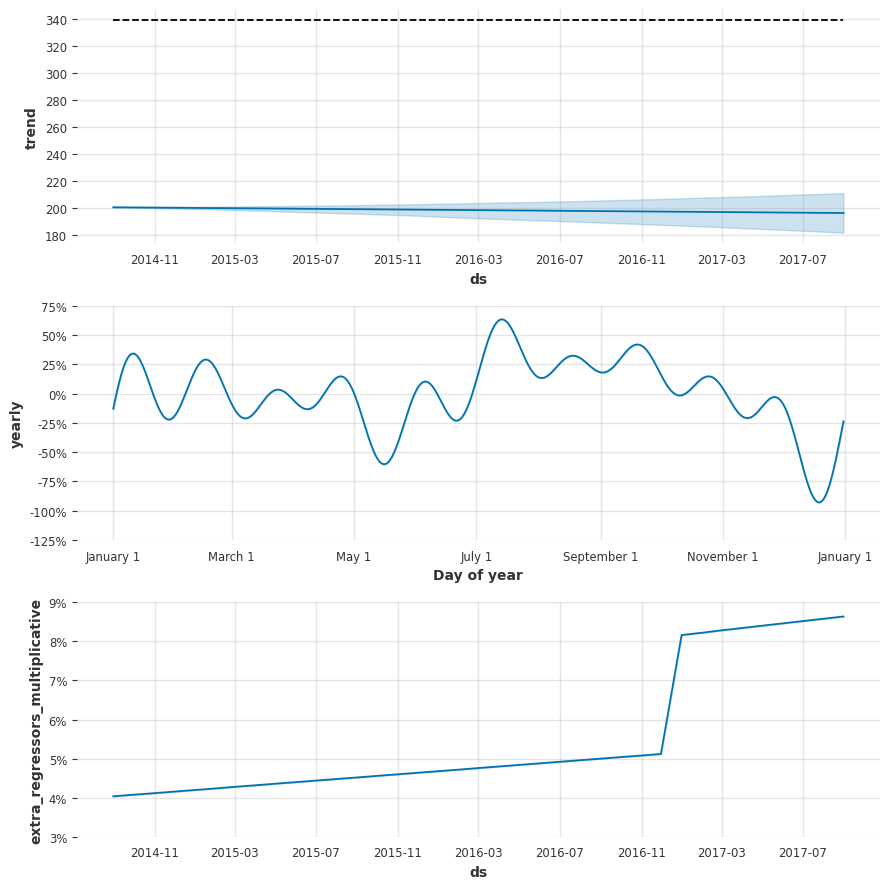

In [311]:
predictions_new_fb, fb_new_mape = predict_fb(data.full_train_val_df['Production'],
                               data.full_train_val_df['Area_rpa'],
                               data.full_train_val_df['Area_npa'],
                               predicted_test_area_rpa,
                               predicted_test_area_npa,
                               data.full_test_df['Production'])

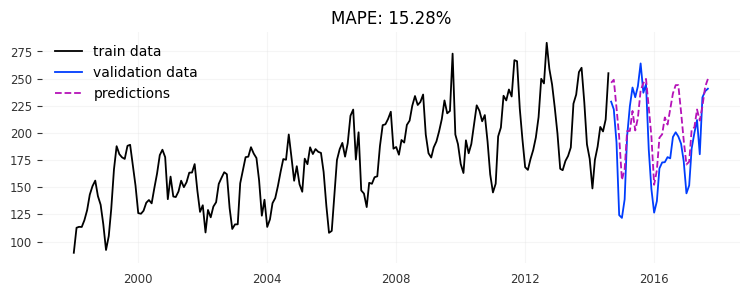

In [312]:
plot_preds(predictions_new_fb,
           fb_new_mape,
           data.full_train_val_df['Production'].values,
           data.full_train_val_df['Production'].index,
           data.full_test_df['Production'].values,
           data.full_test_df['Production'].index)

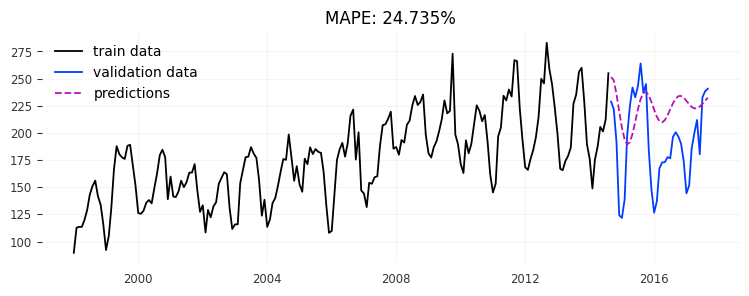

In [313]:
predictions_new_fourier_arima, mape_new_fourier_arima = fit_fourier_arima(data.full_train_val_df['Production'], data.full_test_df['Production'], 12, 5)
plot_preds(predictions_new_fourier_arima,
            mape_new_fourier_arima,
           data.full_train_val_df['Production'].values,
           data.full_train_val_df['Production'].index,
           data.full_test_df['Production'].values,
           data.full_test_df['Production'].index)

In [314]:
best_models = ['SARIMA', 'FB Prophet', 'ARIMA with Fourier']
mapes = [sarima_new_mape, fb_new_mape, mape_new_fourier_arima]

best_models = pd.DataFrame({'model': best_models, 'MAPE': mapes})

In [334]:
models

,model,MAPE
0,SARIMA,11.698
1,SARIMAX,12.714
2,SVR,16.635
3,RF,23.477
4,XGBoost,20.809
5,FB Prophet,10.278
6,LSTM,21.261
7,GRU,16.356
8,CNN,28.172
9,ARIMA with Fourier,14.646


In [335]:
best_models

,model,MAPE
0,SARIMA,20.034
1,FB Prophet,15.280
2,ARIMA with Fourier,24.735


#### Well, predicting test set of these time series is kind of tricky task since it suddenly goes down, and we can observe that again FB Prophet performed the best and besides it is the most stable one, so I choose it for predicting values for the next 12 months.

In [319]:
predicted_future_area_rpa = predicted_future_area_rpa.groupby(predicted_future_area_rpa.index.year).transform('mean')
predicted_future_area_npa = predicted_future_area_npa.groupby(predicted_future_area_npa.index.year).transform('mean')

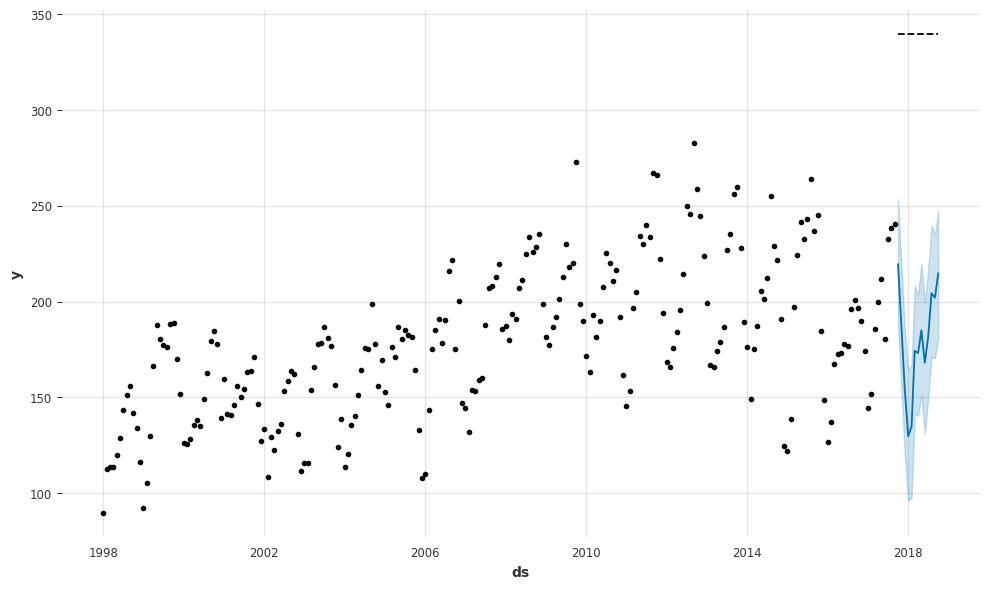

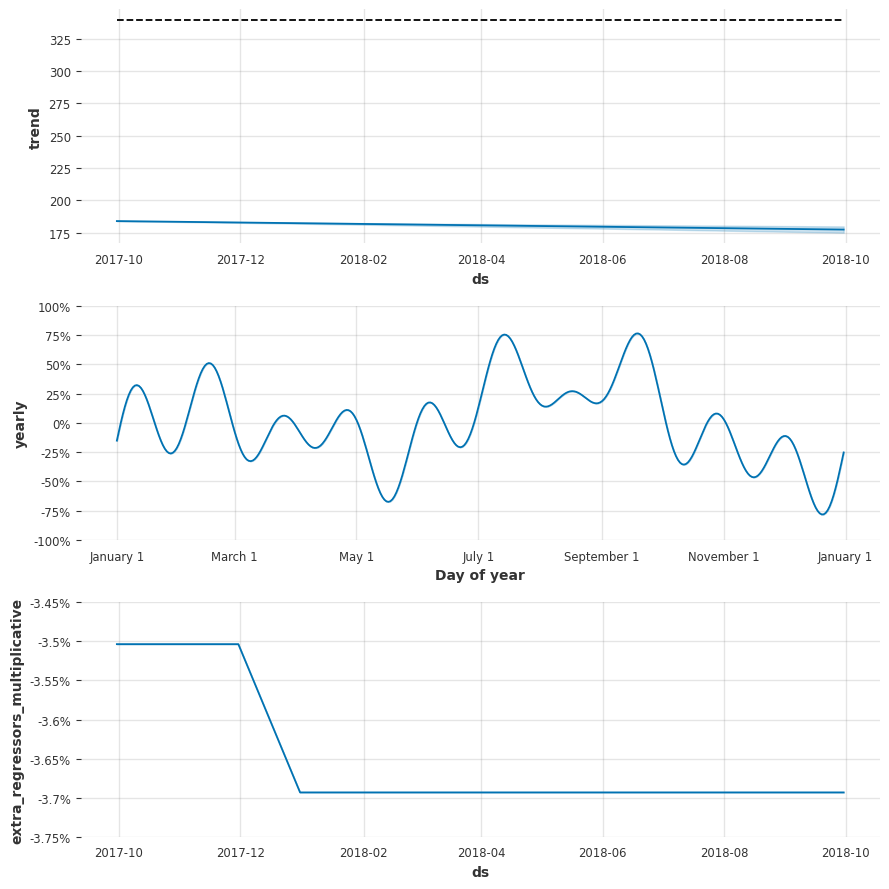

In [320]:
final_predictions = predict_fb(data.full_df['Production'],
                               data.full_df['Area_rpa'],
                               data.full_df['Area_npa'],
                               predicted_future_area_rpa,
                               predicted_future_area_npa)

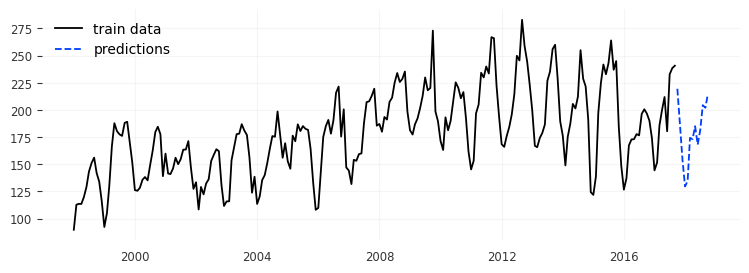

In [321]:
plt.plot(data.full_df['Production'], label='train data')
plt.plot(predicted_future_area_npa.index, final_predictions, linestyle='--', label='predictions')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()


In [322]:
final_predictions.index = predicted_future_area_rpa.index
final_predictions

2017-10-01    219.483168
2017-11-01    186.680502
2017-12-01    154.388515
2018-01-01    129.583870
2018-02-01    134.754986
2018-03-01    174.265150
2018-04-01    173.146265
2018-05-01    185.055249
2018-06-01    168.106222
2018-07-01    181.226079
2018-08-01    204.365106
2018-09-01    202.053932
2018-10-01    214.746871
Name: yhat, dtype: float64

## **Small Conclusion**

#### The performance of the models (especially if their first purpose is not forecasting) significantly depends on the provided features. Unfortunately, among provided additional time series, like Rainfalls and Area there were not such data that would correlate strongly with production, so I guess among all features I created (Area_npa, Area_rpa, previous lags) lags play the main role and have the biggest impact. Nevertheless, it would be a good idea to experiment with introducing different features. I could add Rainfall, but it would be a tricky task predicting it for the next 12 months.
#### It is not surprising, that FB Prophet model showed the best performance than some regressive ML algorithms or simpler forecasting models like SARIMA or SARIMAX. It is way more complex and its first purpose is forecasting. The interesting thing is that SARIMA performed better than SARIMAX. Since as exogenous data I gave SARIMAX Area_npa and Area_rpa I guess, after all, these two don't really have significant impact on the production.